<a href="https://colab.research.google.com/github/tutalae/Coursera_Capstone/blob/main/Capstone_Project_The_Battle_of_Neighborhoods_(Week_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Setting up a café in an urban district of Chiang Mai**
kopkrit saikhiao

A final report for the course "Applied Data Science Capstone" given by IBM on Coursera

Problem's description
(Please read more in the final report!)

By using Data Science and some geometric factors about the relation between districts in HCMC, we can give good answers of following questions to the investors so that they can have a better vision about not only the café but also about other venues in Chiang Mai City (CNX).

How many venues in each district?
How many categories in each district?
How many venues in each category?
What are the most popular categories in each district?
How many clusters we can use to categorize the districts based on the popularity of cafés?
In which districts, the average housing price is low and the number of cafés is low also?
Where there are many people but less cafés?
Visualize all information on the map so that we can have a better look on what we want to find the answers!


Data presentation
1.   List of Ho Chi Minh City administrative units from Wikipedia.
2.   List of housing prices in Ho Chi Minh City from Mogi.
3.   List of housing prices in Ho Chi Minh City from Mogi.
The .json file contains all coordinates where I used it to create choropleth map of Housing Sales Price Index of Ho Chi Minh City. I create this file by myself using https://nominatim.openstreetmap.org



Methodology
1. First, we need to collect the data by scraping the table of HCMC units on the wikipedia page and the average housing price (AHP) on a website. The BeautifulSoup package is very useful in this case.

2. The column Density is calculated later based on columns Population and Area of each district.

3. Throughout the project, we use numpy and pandas packages to manipulate dataframes.

4. We use geopy.geocoders.Nominatim to get the coordinates of districts and add them to the main data frame.

5. We use folium package to visualize the HCMC map with its districts. The central coordinate of each district will be represented as a small circle on top of the city map.

6. We use Foursquare API to explore the venues in each district and segment the districts based on them.

7. For clustering the “Café" venues between districts, we use K-Means Clustering method and the package scikit-learn will help us implement the algorithm on our data. In order to indicate how many K for the method, we try with 10 different values of K from 1 to 10 and use the “elbow" method to choose the most appropriate one.

8. In order to visualize the charts, we use pakage matplotlib.

9. We use again the package folium to visualize the clusters on the main map and the choropleth map of AHP.

**Import all necessary packages**

In [4]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import pandas as pd
import numpy as np

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize  

# Scrape the web to get the data
from bs4 import BeautifulSoup
import requests

import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# find the distances
from scipy.spatial.distance import cdist

import psycopg2 as ps

print('Libraries imported.')

Libraries imported.



Collecting data
We don't have an all-in-one talbe, we have to collect all necessary information from various data tables.

First, we scrape the list of all 19 urban districts from a list of administrative units on a wiki page of Chiang Mai City. 

In [6]:
# http://chiangmai.old.nso.go.th/nso/project/search/result_by_department.jsp

url ="https://raw.githubusercontent.com/tutalae/Coursera_Capstone/main/POPCNXALL.csv"

df = pd.read_csv(url)

print(df.head())

                     District  pop 2015  pop 2016  pop 2017  pop 2018  \
0  Mueang Chiang Mai District    235589    234837    234649    234870   
1         Chom Thong District     66738     66811     66792     66729   
2          Mae Chaem District     59145     59515     59728     60180   
3         Chiang Dao District     91457     91829     92588     93128   
4          Doi Saket District     71316     72064     72571     73220   

   pop 2019  growth- rate 2016  growth- rate 2017  growth- rate 2018  \
0    233632              -0.32              -0.08               0.09   
1     66729               0.11              -0.03              -0.09   
2     60179               0.62               0.36               0.75   
3     96494               0.41               0.82               0.58   
4     74172               1.04               0.70               0.89   

   growth- rate 2019  
0              -0.53  
1               0.00  
2               0.00  
3               3.55  
4            

In [7]:
df.columns

Index(['District', 'pop 2015', 'pop 2016', 'pop 2017', 'pop 2018', 'pop 2019',
       'growth- rate 2016', 'growth- rate 2017', 'growth- rate 2018',
       'growth- rate 2019'],
      dtype='object')

In [8]:
df.shape

(25, 10)

In [9]:

df["District"] = df["District"].str.replace(" District","")
df.head(10)

,District,pop 2015,pop 2016,pop 2017,pop 2018,pop 2019,growth- rate 2016,growth- rate 2017,growth- rate 2018,growth- rate 2019
0,Mueang Chiang Mai,235589,234837,234649,234870,233632,-0.32,-0.08,0.09,-0.53
1,Chom Thong,66738,66811,66792,66729,66729,0.11,-0.03,-0.09,0.00
2,Mae Chaem,59145,59515,59728,60180,60179,0.62,0.36,0.75,0.00
3,Chiang Dao,91457,91829,92588,93128,96494,0.41,0.82,0.58,3.55
4,Doi Saket,71316,72064,72571,73220,74172,1.04,0.70,0.89,1.29
5,Mae Taeng,75893,75699,75790,76512,80303,-0.26,0.12,0.95,4.84
6,Mae Rim,90706,91558,93185,94260,94337,0.93,1.76,1.15,0.08
7,Samoeng,23580,23642,23690,23737,23780,0.26,0.20,0.20,0.18
8,Fang,117589,118075,118324,119635,120759,0.41,0.21,1.10,0.94
9,Mae Ai,77533,77778,78300,78423,78565,0.32,0.67,0.16,0.18


In [10]:
df2 = df

In [11]:
df2

,District,pop 2015,pop 2016,pop 2017,pop 2018,pop 2019,growth- rate 2016,growth- rate 2017,growth- rate 2018,growth- rate 2019
0,Mueang Chiang Mai,235589,234837,234649,234870,233632,-0.32,-0.08,0.09,-0.53
1,Chom Thong,66738,66811,66792,66729,66729,0.11,-0.03,-0.09,0.00
2,Mae Chaem,59145,59515,59728,60180,60179,0.62,0.36,0.75,0.00
3,Chiang Dao,91457,91829,92588,93128,96494,0.41,0.82,0.58,3.55
4,Doi Saket,71316,72064,72571,73220,74172,1.04,0.70,0.89,1.29
5,Mae Taeng,75893,75699,75790,76512,80303,-0.26,0.12,0.95,4.84
6,Mae Rim,90706,91558,93185,94260,94337,0.93,1.76,1.15,0.08
7,Samoeng,23580,23642,23690,23737,23780,0.26,0.20,0.20,0.18
8,Fang,117589,118075,118324,119635,120759,0.41,0.21,1.10,0.94
9,Mae Ai,77533,77778,78300,78423,78565,0.32,0.67,0.16,0.18


In [13]:
df.loc[0, 'District']

'Mueang Chiang Mai'

In [14]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_user_agent")
district = "Mueang Chiang Mai"
city ="Chiang Mai"
country ="TH"
loc = geolocator.geocode(city+','+ country)
print("latitude is :-" ,loc.latitude,"\nlongtitude is:-" ,loc.longitude)

latitude is :- 18.7882778 
longtitude is:- 98.9868056


In [15]:
dt = df.loc[0:, 'District']
dt

0     Mueang Chiang Mai
1            Chom Thong
2             Mae Chaem
3            Chiang Dao
4             Doi Saket
5             Mae Taeng
6               Mae Rim
7               Samoeng
8                  Fang
9                Mae Ai
10                Phrao
11          San Pa Tong
12        San Kamphaeng
13              San Sai
14            Hang Dong
15                  Hot
16              Doi Tao
17                Omkoi
18              Saraphi
19          Wiang Haeng
20          Chai Prakan
21             Mae Wang
22               Mae On
23               Doi Lo
24      Galyani Vadhana
Name: District, dtype: object

In [16]:
print(type(dt))

<class 'pandas.core.series.Series'>


In [17]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_user_agent")
city ="Mueang Chiang Mai"
country ="TH"
loc = geolocator.geocode(city+','+ country)
print("latitude is :-" ,loc.latitude,"\nlongtitude is:-" ,loc.longitude)

latitude is :- 18.7889571 
longtitude is:- 98.9873115


In [18]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_user_agent")
city ="Chom Thong"
country ="TH"
loc = geolocator.geocode(city+','+ country)
print("latitude is :-" ,loc.latitude,"\nlongtitude is:-" ,loc.longitude)

latitude is :- 18.4221125 
longtitude is:- 98.6772798


In [19]:
def find_coor(name):
    city = name
    address = name + " Chiang Mai Thailand"
    geolocator = Nominatim(user_agent="my_user_agent")
    country ="TH"
    loc = geolocator.geocode(city+','+ country)
    latitude = loc.latitude
    longitude = loc.longitude
    return [latitude, longitude]

In [20]:
find_coor(dt.iloc[2])

[18.49924, 98.3627398]

In [21]:
# For District 1 to 12 (numbers)
coords = [find_coor(dist) for dist in df2["District"].iloc[0:].tolist()]
df_coords = pd.DataFrame(coords, columns=["Latitude", "Longitude"])

df2["Latitude"] = df_coords["Latitude"]
df2["Longitude"] = df_coords["Longitude"]

df3 = df2
df3

,District,pop 2015,pop 2016,pop 2017,pop 2018,pop 2019,growth- rate 2016,growth- rate 2017,growth- rate 2018,growth- rate 2019,Latitude,Longitude
0,Mueang Chiang Mai,235589,234837,234649,234870,233632,-0.32,-0.08,0.09,-0.53,18.788957,98.987312
1,Chom Thong,66738,66811,66792,66729,66729,0.11,-0.03,-0.09,0.00,18.422113,98.677280
2,Mae Chaem,59145,59515,59728,60180,60179,0.62,0.36,0.75,0.00,18.499240,98.362740
3,Chiang Dao,91457,91829,92588,93128,96494,0.41,0.82,0.58,3.55,19.368442,98.964982
4,Doi Saket,71316,72064,72571,73220,74172,1.04,0.70,0.89,1.29,18.873195,99.136566
5,Mae Taeng,75893,75699,75790,76512,80303,-0.26,0.12,0.95,4.84,19.121308,98.943384
6,Mae Rim,90706,91558,93185,94260,94337,0.93,1.76,1.15,0.08,18.914458,98.945274
7,Samoeng,23580,23642,23690,23737,23780,0.26,0.20,0.20,0.18,18.847780,98.732032
8,Fang,117589,118075,118324,119635,120759,0.41,0.21,1.10,0.94,19.920420,99.215546
9,Mae Ai,77533,77778,78300,78423,78565,0.32,0.67,0.16,0.18,20.032867,99.298000


In [22]:
df3.drop([ 'pop 2015', 'pop 2016', 'pop 2017',	'pop 2018','growth- rate 2016', 'growth- rate 2017', 'growth- rate 2018', 'growth- rate 2019'], axis=1)

,District,pop 2019,Latitude,Longitude
0,Mueang Chiang Mai,233632,18.788957,98.987312
1,Chom Thong,66729,18.422113,98.677280
2,Mae Chaem,60179,18.499240,98.362740
3,Chiang Dao,96494,19.368442,98.964982
4,Doi Saket,74172,18.873195,99.136566
5,Mae Taeng,80303,19.121308,98.943384
6,Mae Rim,94337,18.914458,98.945274
7,Samoeng,23780,18.847780,98.732032
8,Fang,120759,19.920420,99.215546
9,Mae Ai,78565,20.032867,99.298000


Population on age range in 2019

In [23]:
# http://chiangmai.old.nso.go.th/nso/project/search_option/search_result.jsp

url2 ="https://raw.githubusercontent.com/tutalae/Coursera_Capstone/main/POPAGE.csv"

df4 = pd.read_csv(url2)

print(df4.head())

                     District Population registered in central house file  \
0                       Total                                      23,190   
1              Municipal area                                      12,422   
2          Non-municipal area                                      10,768   
3  Mueang Chiang Mai District                                       5,787   
4         Chom Thong District                                         666   

  Transferring population A Non-Thai national  Unknown   A 0-4  A  5-9  \
0                   3,067             135,160      1.0  76,090  85,216   
1                   1,725              31,844      1.0  25,888  29,419   
2                   1,342             103,316      NaN  50,202  55,797   
3                     869               4,860      NaN   7,958   9,438   
4                     115                 149      NaN   3,255   3,488   

  A 10-14 A 15-19  A 20-24  A 25-29  A 30-34  A 35-39  A 40-44  A 45-49  \
0  87,640  93,107

In [24]:
df4.columns

Index(['District', 'Population registered in central house file',
       'Transferring population', 'A Non-Thai national', 'Unknown', 'A 0-4',
       'A  5-9', 'A 10-14', 'A 15-19', 'A 20-24', 'A 25-29', 'A 30-34',
       'A 35-39', 'A 40-44', 'A 45-49', 'A 50-54', 'A 55-59', 'A 60-64',
       'A 65-69', 'A 70-74', 'A 75-79', 'A 80 and over', 'Total'],
      dtype='object')

In [25]:
df4.drop(['Unknown'], axis=1, inplace = True)

In [26]:
df4

,District,Population registered in central house file,Transferring population,A Non-Thai national,A 0-4,A 5-9,A 10-14,A 15-19,A 20-24,A 25-29,A 30-34,A 35-39,A 40-44,A 45-49,A 50-54,A 55-59,A 60-64,A 65-69,A 70-74,A 75-79,A 80 and over,Total
0,Total,"23,190","3,067","135,160","76,090","85,216","87,640","93,107","109,613","119,755","115,836","124,209","115,171","107,921","118,366","131,220","121,167","86,141","50,393","29,312","46,679","1,779,254"
1,Municipal area,"12,422","1,725","31,844","25,888","29,419","30,233","32,410","43,240","45,603","45,069","49,510","46,546","42,758","46,243","52,384","49,493","36,633","21,201","12,592","20,226","675,440"
2,Non-municipal area,"10,768","1,342","103,316","50,202","55,797","57,407","60,697","66,373","74,152","70,767","74,699","68,625","65,163","72,123","78,836","71,674","49,508","29,192","16,720","26,453","1,103,814"
3,Mueang Chiang Mai District,"5,787",869,"4,860","7,958","9,438","9,830","11,616","16,855","15,918","15,624","17,624","16,894","15,542","16,102","17,655","16,648","13,197","8,005","4,887","8,323","233,632"
4,Chom Thong District,666,115,149,"3,255","3,488","3,501","3,568","4,226","4,805","4,580","5,125","4,694","4,413","4,442","5,092","4,986","3,793","2,282","1,368","2,181","66,729"
5,Mae Chaem District,543,28,299,"3,810","4,194","4,320","4,880","5,091","5,166","4,694","4,450","4,076","3,744","3,667","3,310","2,496","1,817","1,232",863,"1,499","60,179"
6,Chiang Dao District,479,105,"23,422","4,716","5,189","5,438","5,643","6,078","5,589","5,419","4,998","4,448","4,321","4,407","4,771","4,280","2,803","1,767","1,087","1,534","96,494"
7,Doi Saket District,513,103,807,"3,036","3,158","3,170","3,283","4,020","4,990","5,205","6,197","5,613","5,311","5,589","6,504","6,250","4,514","2,532","1,250","2,127","74,172"
8,Mae Taeng District,355,68,"8,423","3,121","3,455","3,507","3,697","4,341","5,121","4,915","5,276","5,022","4,768","5,417","6,399","6,351","4,349","2,264","1,413","2,041","80,303"
9,Mae Rim District,"3,378",523,"4,975","3,965","4,383","4,311","4,567","6,802","6,258","6,159","6,466","6,022","5,570","6,151","6,985","6,631","4,565","2,640","1,515","2,470","94,337"


In [27]:
df4.columns = ['District', 'Population registered in central house file',
       'Transferring population', 'A Non-Thai national', '0-4',
       '5-9', '10-14', '15-19', '20-24', '25-29', '30-34',
       '35-39', '40-44', '45-49', '50-54', '55-59', '60-64',
       '65-69', '70-74', '75-79', '80 and over', 'Total']

df4["District"] = df4["District"].str.replace(" District","")


In [28]:
df4 = df4.set_index("District")
df4.head()

,Population registered in central house file,Transferring population,A Non-Thai national,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80 and over,Total
District,,,,,,,,,,,,,,,,,,,,,
Total,"23,190","3,067","135,160","76,090","85,216","87,640","93,107","109,613","119,755","115,836","124,209","115,171","107,921","118,366","131,220","121,167","86,141","50,393","29,312","46,679","1,779,254"
Municipal area,"12,422","1,725","31,844","25,888","29,419","30,233","32,410","43,240","45,603","45,069","49,510","46,546","42,758","46,243","52,384","49,493","36,633","21,201","12,592","20,226","675,440"
Non-municipal area,"10,768","1,342","103,316","50,202","55,797","57,407","60,697","66,373","74,152","70,767","74,699","68,625","65,163","72,123","78,836","71,674","49,508","29,192","16,720","26,453","1,103,814"
Mueang Chiang Mai,"5,787",869,"4,860","7,958","9,438","9,830","11,616","16,855","15,918","15,624","17,624","16,894","15,542","16,102","17,655","16,648","13,197","8,005","4,887","8,323","233,632"
Chom Thong,666,115,149,"3,255","3,488","3,501","3,568","4,226","4,805","4,580","5,125","4,694","4,413","4,442","5,092","4,986","3,793","2,282","1,368","2,181","66,729"


In [29]:
df5 =df4.iloc[3,:]

In [30]:
print(type(df5))

<class 'pandas.core.series.Series'>


In [31]:
df5 = df5.drop(["Population registered in central house file","Transferring population","A Non-Thai national","Total"], axis=0)
df5=df5.to_frame()

In [81]:
df6 = df5

In [82]:
df6

,Mueang Chiang Mai,index,age
0-4,"7,958",0,0-4
5-9,"9,438",1,5-9
10-14,"9,830",2,10-14
15-19,"11,616",3,15-19
20-24,"16,855",4,20-24
25-29,"15,918",5,25-29
30-34,"15,624",6,30-34
35-39,"17,624",7,35-39
40-44,"16,894",8,40-44
45-49,"15,542",9,45-49


In [83]:
df6.index

Index(['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
       '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79',
       '80 and over'],
      dtype='object')

In [84]:
df6["index"] = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
df6["age"] = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
       '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79',
       '80 and over']
df6.set_index("index")

,Mueang Chiang Mai,age
index,,
0,"7,958",0-4
1,"9,438",5-9
2,"9,830",10-14
3,"11,616",15-19
4,"16,855",20-24
5,"15,918",25-29
6,"15,624",30-34
7,"17,624",35-39
8,"16,894",40-44


In [85]:
df6 = df6[["index","age","Mueang Chiang Mai"]]
df6 = df6.set_index("index")
df6.head()

,age,Mueang Chiang Mai
index,,
0,0-4,"7,958"
1,5-9,"9,438"
2,10-14,"9,830"
3,15-19,"11,616"
4,20-24,"16,855"


In [86]:
df6["Mueang Chiang Mai"] = df6["Mueang Chiang Mai"].str.replace(",","")

In [87]:
df6["Mueang Chiang Mai"] = df6["Mueang Chiang Mai"].astype("float")


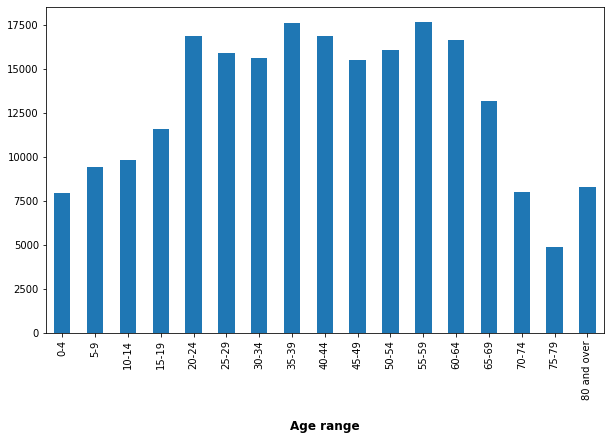

In [111]:
ax = df6["Mueang Chiang Mai"].plot(kind = "bar", figsize=(10, 6))
ax.set_xlabel("Age range", labelpad=20, weight='bold', size=12)
ax.set_xticklabels(['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
       '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79',
       '80 and over'])

ax

In [118]:
[cnx_lat, cnx_long] = find_coor("chiang mai")
print('The geograpical coordinate of Chiang Mai City are {}, {}.'.format(cnx_lat, cnx_long))

The geograpical coordinate of Chiang Mai City are 18.7882778, 98.9868056.


In [119]:

map_hcm = folium.Map(location=[cnx_lat, cnx_long], zoom_start=11)
for lat, lng, dis in zip(df3['Latitude'], df3['Longitude'], df['District']):
    label = '{}'.format(dis)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hcm)  

map_hcm


Define Foursquare Credentials and Version

In [141]:
CLIENT_ID = 'KOP1BQD4WD04PHXHOSJOIID0UXP51GC3OL1OJZX5YSQOX030' # your Foursquare ID
CLIENT_SECRET = 'WO0FY4KQ1MN2X15O3GBC0GKZRCKKOTQW40NAWTYXNXRTVZPD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


Explore the venues of urbant districts
First, let's create a function to repeat the same process to all the districts of Chiang Mai.

In [162]:
  def getNearbyVenues(names, latitudes, longitudes, radius=1500, LIMIT=500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [163]:
cnx_venues = getNearbyVenues(names=df3['District'],
                             latitudes=df3['Latitude'],
                             longitudes=df3['Longitude']
                            )

In [164]:
cnx_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mueang Chiang Mai,18.788957,98.987312,U Chiang Mai Hotel,18.788485,98.987138,Hotel
1,Mueang Chiang Mai,18.788957,98.987312,Krua Dabb Lob (ครัวดาบลพ),18.788260,98.985535,Thai Restaurant
2,Mueang Chiang Mai,18.788957,98.987312,Chiangmai Walking Street (ถนนคนเดินเชียงใหม่),18.788189,98.988720,Night Market
3,Mueang Chiang Mai,18.788957,98.987312,ห้องสมุดฟื้นบ้านย่านเวียงเชียงใหม่,18.790276,98.986094,Library
4,Mueang Chiang Mai,18.788957,98.987312,Lamphu House,18.787508,98.989329,Hotel


In [165]:
cnx_group = cnx_venues.groupby('District').count().reset_index()
cnx_group

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Chai Prakan,10,10,10,10,10,10
1,Chiang Dao,12,12,12,12,12,12
2,Chom Thong,30,30,30,30,30,30
3,Doi Lo,1,1,1,1,1,1
4,Doi Saket,16,16,16,16,16,16
5,Doi Tao,7,7,7,7,7,7
6,Fang,29,29,29,29,29,29
7,Hang Dong,22,22,22,22,22,22
8,Hot,7,7,7,7,7,7
9,Mae Ai,5,5,5,5,5,5


In [166]:
print('In above table, there are {} uniques categories.'.format(len(chiang_mai_venues['Venue Category'].unique())))

In above table, there are 107 uniques categories.



**Results** 

The list of unique categories
The list of first 50 categories.

In [167]:
cnx_venues['Venue Category'].unique()[:50]

array(['Hotel', 'Thai Restaurant', 'Night Market', 'Library',
       'Noodle House', 'Asian Restaurant',
       'Vegetarian / Vegan Restaurant', 'Food Truck', 'Coffee Shop',
       'Spa', 'Farm', 'Herbs & Spices Store', 'Buddhist Temple', 'Café',
       'Japanese Restaurant', 'History Museum', 'Juice Bar', 'Resort',
       'Dessert Shop', 'Jazz Club', 'Bakery', 'Pizza Place', 'Hostel',
       'Italian Restaurant', 'Burger Joint', 'Bed & Breakfast',
       'Historic Site', 'Museum', 'Health & Beauty Service', 'Bar',
       'Som Tum Restaurant', 'Chinese Restaurant', 'Bagel Shop',
       'Indian Restaurant', 'Massage Studio', 'French Restaurant',
       'Motel', 'Restaurant', 'BBQ Joint', 'Food Stand', 'Beer Bar',
       'Street Food Gathering', 'Convenience Store',
       'Fried Chicken Joint', 'Shopping Mall', 'Flea Market',
       'Deli / Bodega', 'Hotpot Restaurant', 'Buffet', 'Movie Theater'],
      dtype=object)

**Number of venues in each district**

We plot a chart in order to compare visually the different of number of venues between districts.

Text(0, 0.5, 'Number of venues')

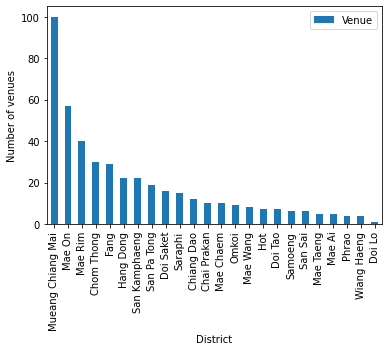

In [134]:
ax = cnx_group.sort_values(by="Venue", ascending=False).plot(x="District", y="Venue", kind="bar")
ax.set_ylabel("Number of venues")

In [168]:
most_venues = cnx_venues.groupby('Venue Category').count().sort_values(by="Venue", ascending=False)
most_venues.head(15)

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Coffee Shop,55,55,55,55,55,55
Thai Restaurant,39,39,39,39,39,39
Noodle House,32,32,32,32,32,32
Café,30,30,30,30,30,30
Convenience Store,25,25,25,25,25,25
Asian Restaurant,20,20,20,20,20,20
Hotel,13,13,13,13,13,13
Flea Market,10,10,10,10,10,10
Restaurant,9,9,9,9,9,9


Top 10 venue categories for each district

In [169]:
# one hot encoding
cnx_onehot = pd.get_dummies(chiang_mai_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
cnx_onehot['District'] = df3['District'] 

# move district column to the first column
fixed_columns = [cnx_onehot.columns[-1]] + list(cnx_onehot.columns[:-1])
cnx_onehot = cnx_onehot[fixed_columns]

# group the rows by district and by taking the mean of the frequency of occurrence of each category
cnx_grouped = cnx_onehot.groupby('District').mean().reset_index()

cnx_grouped.head(25)

,District,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Bubble Tea Shop,Buddhist Temple,Buffet,Burger Joint,Bus Station,Cafeteria,Café,Chinese Restaurant,City,Clothing Store,Coffee Shop,College Gym,Construction & Landscaping,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Dumpling Restaurant,Electronics Store,Event Service,Event Space,Farm,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gourmet Shop,Grocery Store,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Korean Restaurant,Lake,Library,Liquor Store,Market,Massage Studio,Middle Eastern Restaurant,Miscellaneous Shop,Motel,Movie Theater,Museum,Night Market,Noodle House,Outdoor Sculpture,Pakistani Restaurant,Pastry Shop,Pet Store,Pizza Place,Plaza,Pub,Resort,Restaurant,River,Salad Place,Sandwich Place,Shop & Service,Shopping Mall,Som Tum Restaurant,Spa,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Vegetarian / Vegan Restaurant
0,Chai Prakan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,Chiang Dao,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Chom Thong,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,Doi Lo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Doi Saket,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Doi Tao,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,Fang,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,Galyani Vadhana,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Hang Dong,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,Hot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [151]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cnx_10 = pd.DataFrame(columns=columns)
cnx_10['District'] = cnx_grouped['District']

for ind in np.arange(cnx_grouped.shape[0]):
    cnx_10.iloc[ind, 1:] = return_most_common_venues(cnx_grouped.iloc[ind, :], num_top_venues)

cnx_10

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Chai Prakan,Thai Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Dumpling Restaurant,Electronics Store
1,Chiang Dao,Library,Vegetarian / Vegan Restaurant,Farmers Market,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Dumpling Restaurant,Electronics Store
2,Chom Thong,Thai Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Dumpling Restaurant,Electronics Store
3,Doi Lo,Japanese Restaurant,Fast Food Restaurant,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Dumpling Restaurant,Electronics Store,Event Service
4,Doi Saket,Hotel,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Dumpling Restaurant,Electronics Store
5,Doi Tao,Spa,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Dumpling Restaurant,Electronics Store
6,Fang,Thai Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Dumpling Restaurant,Electronics Store
7,Galyani Vadhana,Coffee Shop,College Gym,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Dumpling Restaurant,Electronics Store,Event Service
8,Hang Dong,Spa,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Dumpling Restaurant,Electronics Store
9,Hot,Farm,Vegetarian / Vegan Restaurant,College Gym,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Dumpling Restaurant,Electronics Store


**Consider the data relating to category "café" only**

In [156]:

cnx_grouped_cafe = cnx_grouped[["District", "Coffee Shop"]]
cnx_grouped_cafe

,District,Coffee Shop
0,Chai Prakan,0
1,Chiang Dao,0
2,Chom Thong,0
3,Doi Lo,0
4,Doi Saket,0
5,Doi Tao,0
6,Fang,0
7,Galyani Vadhana,1
8,Hang Dong,0
9,Hot,0
